# Coastal Kelvin Wave Test Case

simulating a coastal kelvin wave

In [1]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS/MPAS_Ocean/"

In [2]:
include(CODE_ROOT * "mode_forward/time_steppers.jl")
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()

using Printf # for print formatting

In [67]:
mpasOcean = MPAS_Ocean(
                CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh",
                "culled_mesh.nc", "mesh.nc", periodicity="NonPeriodic_x")
ocn_init_routines_compute_max_level!(mpasOcean)

In [158]:
mpasOcean = MPAS_Ocean(
                CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh/ConvergenceStudyMeshes",
                "culled_mesh_64.nc", "mesh_64.nc", periodicity="NonPeriodic_x")
ocn_init_routines_compute_max_level!(mpasOcean)

In [159]:
mpasOcean.fEdge .= 1e-4

12416-element Vector{Float64}:
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 ⋮
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001
 0.0001

In [160]:
meanCoriolisParameterf = sum(mpasOcean.fEdge) / length(mpasOcean.fEdge)

0.0001

In [161]:
meanFluidThicknessH = sum(mpasOcean.bottomDepth)/length(mpasOcean.bottomDepth)

1000.0

In [162]:
c = sqrt(mpasOcean.gravity*meanFluidThicknessH)

98.99494936611666

In [163]:
rossbyRadiusR = c/meanCoriolisParameterf

989949.4936611665

## the lateral profile of the kelvin wave, can be any function

In [164]:
lYedge = maximum(mpasOcean.yEdge) - minimum(mpasOcean.yEdge)

4.330127018922193e6

In [165]:
function lateralProfileGaussian(y)
    mu = lYedge/2#20.0e5
    sigma = 3.0e5
    return 1e-3*exp(- (y .% lYedge -mu)^2 / sigma^2) #* cos(y*5.0e-6)
end

lateralProfileGaussian (generic function with 1 method)

In [166]:
function lateralProfilePeriodic(y)
    return 1e-3*cos(y/lYedge * 4 * pi)
end

lateralProfilePeriodic (generic function with 1 method)

In [167]:
lateralProfile = lateralProfilePeriodic

lateralProfilePeriodic (generic function with 1 method)

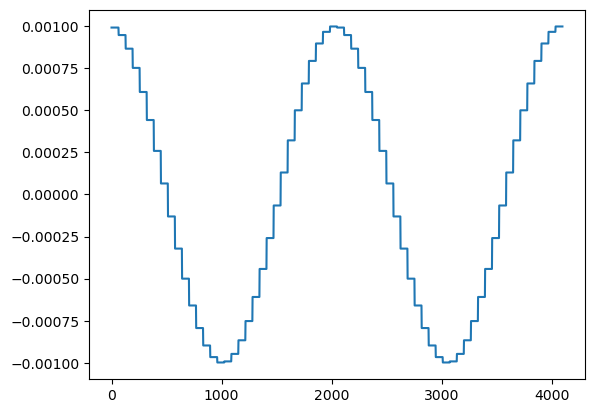

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb8e0926640>

In [168]:
plot(lateralProfile.(mpasOcean.yCell))

## set the velocity and ssh to be a kelvin wave

In [169]:
function kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t=0)
    v = sqrt(mpasOcean.gravity*meanFluidThicknessH) * lateralProfile(mpasOcean.yEdge[iEdge] .+ c*t) * exp(-mpasOcean.xEdge[iEdge]/rossbyRadiusR)
    return v*sin(mpasOcean.angleEdge[iEdge])
end

kelvinWaveExactNormalVelocity (generic function with 2 methods)

In [170]:
function kelvinWaveExactSSH(mpasOcean, iCell, t=0)
    return - meanFluidThicknessH * lateralProfile(mpasOcean.yCell[iCell] .+ c*t) * exp(-mpasOcean.xCell[iCell]/rossbyRadiusR)
end

kelvinWaveExactSSH (generic function with 2 methods)

In [171]:
function kelvinWaveExactSolution!(mpasOcean, t=0)
    for iCell in 1:mpasOcean.nCells
        mpasOcean.sshCurrent[iCell] = kelvinWaveExactSSH(mpasOcean, iCell, t)
    end
    
    for iEdge in 1:mpasOcean.nEdges
        mpasOcean.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)
    end
end

kelvinWaveExactSolution! (generic function with 2 methods)

In [172]:
function boundaryCondition!(mpasOcean, t)
    for iEdge in 1:mpasOcean.nEdges
        if mpasOcean.boundaryEdge[iEdge] == 1.0
            mpasOcean.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(mpasOcean, iEdge, t)
        end
    end
    
end

boundaryCondition! (generic function with 1 method)

In [173]:
kelvinWaveExactSolution!(mpasOcean)

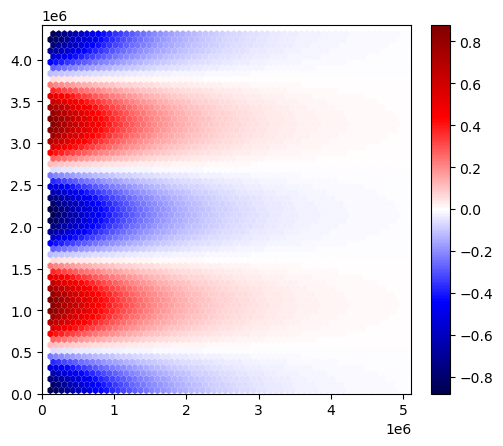

In [174]:
fig, ax, _, _ = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

# Simulate wave

In [175]:
sqrt(mpasOcean.gravity*meanFluidThicknessH)

98.99494936611666

In [176]:
mpasOcean.dcEdge[1] / mpasOcean.dt

989.9494936611666

In [177]:
T = 25000

25000

In [178]:
T/mpasOcean.dt

316.7838379715765

In [179]:
nFrames = 50

sshOverTime = zeros(Float64, (nFrames, mpasOcean.nCells))

saveInterval = Int(round(T/mpasOcean.dt / nFrames))

t = 0

for i in 1:nFrames
    for j in 1:saveInterval
        
        calculate_normal_velocity_tendency!(mpasOcean)
    
        update_normal_velocity_by_tendency!(mpasOcean)

        
        boundaryCondition!(mpasOcean, t)

        
        calculate_ssh_tendency!(mpasOcean)

        update_ssh_by_tendency!(mpasOcean)

        t += mpasOcean.dt
    end
    sshOverTime[i,:] .= mpasOcean.sshCurrent[:]
end

In [180]:
nFrames*saveInterval*mpasOcean.dt

23675.450262942202

## animate simulation

In [181]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fb8e0ca1220>

In [182]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

# show exact solution

In [123]:
sshOverTimeExact = zeros(Float64, (nFrames, mpasOcean.nCells))

t = 0

for i in 1:nFrames
    t += saveInterval*mpasOcean.dt
    kelvinWaveExactSolution!(mpasOcean, t)
    sshOverTimeExact[i,:] .= mpasOcean.sshCurrent[:]
end

In [124]:
fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTimeExact[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTimeExact[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fb8e8b6a1f0>

In [125]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

# difference between exact and numerical solution

In [131]:
fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTimeExact[1,:], cMin=-cMax/100, cMax=cMax/100)

function nextFrame(i)
    col.set_array(sshOverTimeExact[i+1,:] - sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7fb8e1203a60>

In [132]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [128]:
maximum(abs.(sshOverTimeExact[:,:] - sshOverTime[:,:]))

0.004257652172327431

In [33]:
maximum(abs.(sshOverTimeExact))

0.9270373118181899

In [291]:
diff(sort(collect(Set(mpasOcean.yCell))))

99-element Vector{Float64}:
 43301.270189221934
 43301.270189221905
 43301.270189221934
 43301.27018922195
 43301.27018922198
 43301.27018922189
 43301.27018922195
 43301.27018922189
 43301.27018922195
 43301.27018922183
 43301.27018922195
 43301.27018922189
 43301.27018922195
     ⋮
 43301.27018922195
 43301.27018922195
 43301.27018922195
 43301.27018922195
 43301.27018922148
 43301.27018922195
 43301.27018922195
 43301.27018922195
 43301.27018922195
 43301.270189222414
 43301.27018922195
 43301.27018922195

In [292]:
numericalProfile = zeros(100)

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [293]:
exactProfile = zeros(100)

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [294]:
sort(collect(Set(mpasOcean.xCell)))

200-element Vector{Float64}:
  75000.0
 100000.0
 125000.0
 150000.0
 175000.0
 200000.0
 225000.0
 250000.0
 275000.0
 300000.0
 325000.0
 350000.0
 375000.0
      ⋮
      4.775e6
      4.8e6
      4.825e6
      4.85e6
      4.875e6
      4.9e6
      4.925e6
      4.95e6
      4.975e6
      5.0e6
      5.025e6
      5.05e6

In [295]:
T = size(sshOverTime)[1]*saveInterval*mpasOcean.dt

25253.813613804858

In [296]:
T/saveInterval/mpasOcean.dt

50.0

In [297]:
size(sshOverTime)

(50, 10000)

In [298]:
maximum(mpasOcean.yEdge) - minimum(mpasOcean.yEdge)

4.330127018922193e6

In [299]:
lYcell

4.286825748732972e6

In [300]:
lYcell + 43301.27018922148

4.330127018922193e6

In [301]:
mpasOcean.lY

4.373428289111415e6

In [302]:
function lateralProfilePeriodic(y)
    return 1e-3*cos(y/4.33e6 * 4 * pi)
end

lateralProfilePeriodic (generic function with 1 method)

In [303]:
for iCell in 1:mpasOcean.nCells
    if mpasOcean.xCell[iCell] <= 100000
        numericalProfile[Int(round(mpasOcean.yCell[iCell]/43301.27018922183))] = sshOverTime[Int(round(T/(saveInterval*mpasOcean.dt))),iCell]
        exactProfile[Int(round(mpasOcean.yCell[iCell]/43301.27018922183))] = kelvinWaveExactSSH(mpasOcean, iCell, T)
    end
end

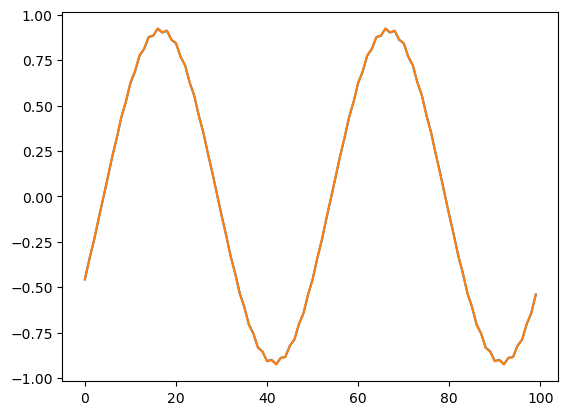

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f59f712a310>

In [304]:
plot(numericalProfile)
plot(exactProfile)